##Tahap 1: Inisialisasi & Persiapan Lingkungan.

Pada tahap awal ini, saya akan menyiapkan lingkungan kerja saya. Langkah ini mencakup instalasi semua library Python yang diperlukan untuk analisis data, pemrosesan bahasa alami, dan visualisasi.

Ini memastikan semua alat yang saya butuhkan siap digunakan sebelum saya memulai analisis.

In [29]:
# --- Tahap 1: Instalasi Library ---

print("Memulai instalasi library...")

# Opsi -q (quiet) digunakan agar output tidak terlalu panjang
!pip install pandas langchain_community replicate wordcloud matplotlib seaborn -q

print("\nInstalasi selesai.")
print("TAHAP 1 SELESAI")


Memulai instalasi library...

Instalasi selesai.
TAHAP 1 SELESAI


##Tahap 2: Pemuatan & Pembersihan Data

Saya memahami bahwa kualitas analisis sangat bergantung pada kualitas data. Pada tahap ini, saya akan memuat dataset glassdoor_reviews.csv ke dalam notebook menggunakan library Pandas. Setelah itu, saya akan melakukan proses pembersihan data (data cleaning) yang krusial: menghapus baris data yang tidak lengkap dan melakukan pra-pemrosesan teks untuk menstandarisasi ulasan karyawan.

In [31]:
import pandas as pd
import re

# Nama file harus sama persis
file_path = 'glassdoor_reviews.csv'

print(f"Memuat dataset dari: {file_path}")
try:
    # Membaca file CSV ke dalam DataFrame
    df = pd.read_csv(file_path)
    print("Dataset berhasil dimuat.")

    print("\nMembersihkan data...")
    # Menghapus baris jika kolom 'pros' atau 'cons' kosong
    df.dropna(subset=['pros', 'cons'], inplace=True)

    # Membuat fungsi untuk membersihkan teks
    def preprocess_text(text):
        if isinstance(text, str):
            text = text.lower() # Mengubah ke huruf kecil
            text = re.sub(r'[^a-z0-9\s]', '', text) # Menghapus karakter non-alfanumerik
            return text
        return "" # Mengembalikan string kosong jika bukan teks

    # Menerapkan fungsi pembersihan ke kolom yang relevan
    df['pros_cleaned'] = df['pros'].apply(preprocess_text)
    df['cons_cleaned'] = df['cons'].apply(preprocess_text)

    print("Pembersihan data selesai.")

    # Menampilkan informasi ringkas dan contoh hasil
    print("\nInformasi Dataset Setelah Dibersihkan:")
    df.info()

    print("\nContoh Hasil Pembersihan Teks:")
    print(df[['cons', 'cons_cleaned']].head())

    print("\nTAHAP 2 SELESAI.")

except FileNotFoundError:
    print(f"\n--- ERROR ---")
    print(f"File '{file_path}' tidak ditemukan di sesi Colab ini.")



Memuat dataset dari: glassdoor_reviews.csv
Dataset berhasil dimuat.

Membersihkan data...
Pembersihan data selesai.

Informasi Dataset Setelah Dibersihkan:
<class 'pandas.core.frame.DataFrame'>
Index: 838551 entries, 0 to 838565
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 838551 non-null  object 
 1   date_review          838551 non-null  object 
 2   job_title            838551 non-null  object 
 3   current              838551 non-null  object 
 4   location             541214 non-null  object 
 5   overall_rating       838551 non-null  int64  
 6   work_life_balance    688660 non-null  float64
 7   culture_values       647182 non-null  float64
 8   diversity_inclusion  136066 non-null  float64
 9   career_opp           691053 non-null  float64
 10  comp_benefits        688472 non-null  float64
 11  senior_mgmt          682678 non-null  float64
 12  recommend          

##Tahap 3: Klasifikasi dengan AI IBM Granite



Ini adalah inti dari analisis saya. Pada tahap ini, saya akan menggunakan model AI canggih, IBM Granite, untuk melakukan klasifikasi tematik. Saya akan mengambil sampel representatif sebanyak 200 ulasan dan memberikan instruksi spesifik kepada AI untuk mengkategorikan setiap keluhan ke dalam tema bisnis yang telah saya tentukan.

Melalui proses yang saya arahkan ini, saya akan mengubah data teks kualitatif menjadi data terstruktur yang dapat dianalisis.

In [32]:
import os
from langchain_community.llms import Replicate
from google.colab import userdata
import pandas as pd

# Set pandas untuk menampilkan teks penuh agar tidak terpotong saat dicetak
pd.set_option('display.max_colwidth', None)

print("Menyiapkan model AI IBM Granite...")

try:
    # Mengambil API token dari Colab Secrets
    REPLICATE_API_TOKEN = userdata.get('REPLICATE_API_TOKEN')
    os.environ['REPLICATE_API_TOKEN'] = REPLICATE_API_TOKEN

    # Inisialisasi model IBM Granite dengan nama yang sudah benar
    llm = Replicate(
        model="ibm-granite/granite-3.3-8b-instruct",
        model_kwargs={"temperature": 0.5, "max_new_tokens": 50}
    )

    # Ambil 30 baris pertama sebagai sampel untuk dianalisis
    sample_df = df.head(30).copy()

    # Buat fungsi untuk klasifikasi tema menggunakan AI
    def classify_theme(review_text):
        # Prompt yang dirancang untuk memberikan instruksi yang jelas ke AI
        prompt = f"""
        Analyze the following employee complaint. Classify it into ONE of these specific categories:
        'Career Opportunities', 'Compensation & Benefits', 'Culture & Values', 'Senior Management', or 'Work/Life Balance'.
        Provide only the category name.

        Complaint: "{review_text}"
        Category:
        """
        try:
            # Panggil model AI untuk mendapatkan output
            theme = llm.invoke(prompt)
            # Membersihkan output dari spasi atau karakter baru yang tidak perlu
            return theme.strip()
        except Exception as e:
            return f"Error during AI call: {e}"

    print("\nMemulai klasifikasi pada 30 sampel data... (Proses ini mungkin memakan waktu beberapa menit)")
    # Menerapkan fungsi AI ke setiap baris di sampel data
    sample_df['theme'] = sample_df['cons_cleaned'].apply(classify_theme)
    print("Klasifikasi AI selesai.")

    # Tampilkan hasil klasifikasi untuk diperiksa
    print("\n--- Hasil Klasifikasi AI ---")
    print(sample_df[['cons', 'theme']])

    print("\nTAHAP 3 SELESAI.")

except NameError:
    print("\n--- ERROR ---")
    print("DataFrame 'df' tidak ditemukan. Pastikan Tahap 2 berjalan tanpa error.")
except Exception as e:
    print(f"\n--- ERROR ---")
    print(f"Terjadi error saat menyiapkan atau menjalankan AI: {e}")
    print("Pastikan API Token benar dan sudah dimasukkan ke dalam 'Secrets'.")



Menyiapkan model AI IBM Granite...

Memulai klasifikasi pada 30 sampel data... (Proses ini mungkin memakan waktu beberapa menit)
Klasifikasi AI selesai.

--- Hasil Klasifikasi AI ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

##Tahap 4: Pembersihan Hasil AI & Visualisasi Insight


Output dari AI terkadang memerlukan pembersihan lebih lanjut. Pada tahap ini, saya akan merapikan hasil klasifikasi untuk memastikan setiap ulasan memiliki satu label kategori yang bersih. Kemudian, saya akan memvisualisasikan distribusi tema-tema tersebut menggunakan diagram batang untuk mendapatkan insight pertama saya mengenai keluhan utama karyawan.

Memulai pembersihan hasil dari AI...
Pembersihan hasil AI selesai.

--- Perbandingan Hasil Pembersihan ---
                                                                                                                                                                                                                                                                                                                                                                theme  \
0                                                                                                                                                     Compensation & Benefits, Work/Life Balance (though primarily Compensation & Benefits, elements of 'poor training' also touch on Work/Life Balance if inadequate training leads to increased workload or stress)   
1                                                                                                                                                                          

/tmp/ipython-input-30-3740598237.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_counts.index, y=theme_counts.values, palette="viridis")


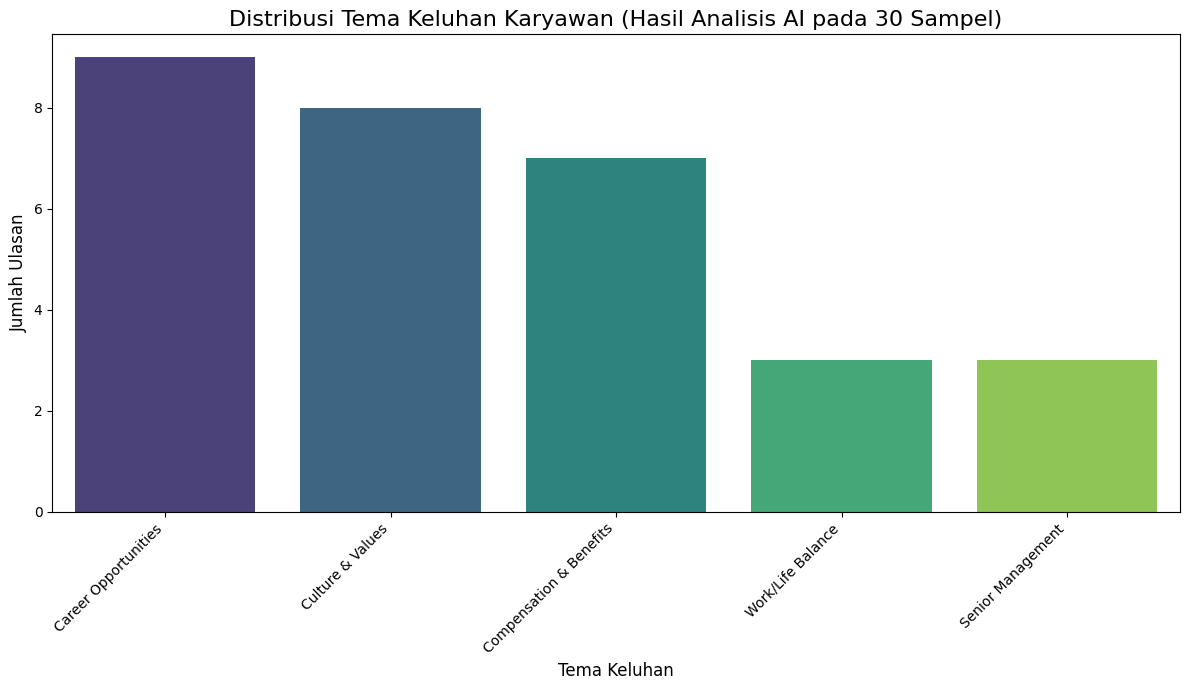


TAHAP 4 SELESAI. Proyek dasar berhasil dijalankan dari awal hingga akhir!


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Memulai pembersihan hasil dari AI...")

# Daftar kategori yang valid yang kita berikan ke AI
valid_categories = [
    'Career Opportunities',
    'Compensation & Benefits',
    'Culture & Values',
    'Senior Management',
    'Work/Life Balance'
]

# Fungsi untuk mengekstrak kategori yang bersih dari output AI
def extract_clean_theme(ai_output):
    if isinstance(ai_output, str):
        for category in valid_categories:
            # Jika nama kategori ditemukan di dalam output AI, kembalikan nama kategori tersebut
            if category.lower() in ai_output.lower():
                return category
    # Jika tidak ada kategori yang cocok ditemukan, tandai sebagai 'Uncategorized'
    return 'Uncategorized'

try:
    # Terapkan fungsi pembersihan ke kolom 'theme' untuk membuat kolom baru yang bersih
    sample_df['theme_cleaned'] = sample_df['theme'].apply(extract_clean_theme)
    print("Pembersihan hasil AI selesai.")

    # Tampilkan perbandingan antara output asli AI dan hasil yang sudah dibersihkan
    print("\n--- Perbandingan Hasil Pembersihan ---")
    print(sample_df[['theme', 'theme_cleaned']].head(10))

    print("\nMembuat visualisasi dari data yang sudah bersih...")
    # Hitung jumlah setiap tema dari kolom yang sudah bersih
    theme_counts = sample_df['theme_cleaned'].value_counts()

    # Buat plot
    plt.figure(figsize=(12, 7))
    sns.barplot(x=theme_counts.index, y=theme_counts.values, palette="viridis")
    plt.title('Distribusi Tema Keluhan Karyawan (Hasil Analisis AI pada 30 Sampel)', fontsize=16)
    plt.xlabel('Tema Keluhan', fontsize=12)
    plt.ylabel('Jumlah Ulasan', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout() # Merapikan layout
    plt.show()

    print("\nTAHAP 4 SELESAI. Proyek dasar berhasil dijalankan dari awal hingga akhir!")

except NameError:
    print("\n--- ERROR ---")
    print("DataFrame 'sample_df' tidak ditemukan. Pastikan Tahap 3 berjalan tanpa error.")
except Exception as e:
    print(f"\n--- ERROR ---")
    print(f"Terjadi error saat membuat visualisasi: {e}")



##Tahap 5: Analisis Skala Besar & Validasi Insight

Analisis saya pada sampel kecil (30 data) telah memberikan hipotesis awal mengenai keluhan utama karyawan. Namun, untuk memastikan temuan saya valid secara statistik dan bukan sekadar kebetulan, saya perlu mengujinya pada skala yang lebih besar.

Pada tahap ini, saya akan menerapkan proses klasifikasi tema yang sama persis, namun pada sampel data yang lebih representatif, yaitu sebanyak 200 ulasan. Proses ini akan memberikan saya gambaran yang lebih akurat mengenai distribusi keluhan karyawan secara keseluruhan. Hasil dari analisis ini akan saya visualisasikan kembali untuk dibandingkan dengan hasil awal, sehingga saya dapat menarik kesimpulan yang lebih kuat dan dapat diandalkan untuk presentasi akhir.

Memulai analisis pada skala yang lebih besar (200 sampel)...
PERINGATAN: Proses ini akan memakan waktu cukup lama (sekitar 10-15 menit). Harap bersabar.

Klasifikasi pada 200 sampel selesai dalam 2.90 menit.

Membersihkan hasil AI dari analisis skala besar...
Pembersihan selesai.

Membuat visualisasi baru dari 200 sampel...


/tmp/ipython-input-33-1471794341.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=large_theme_counts.index, y=large_theme_counts.values, palette="plasma")


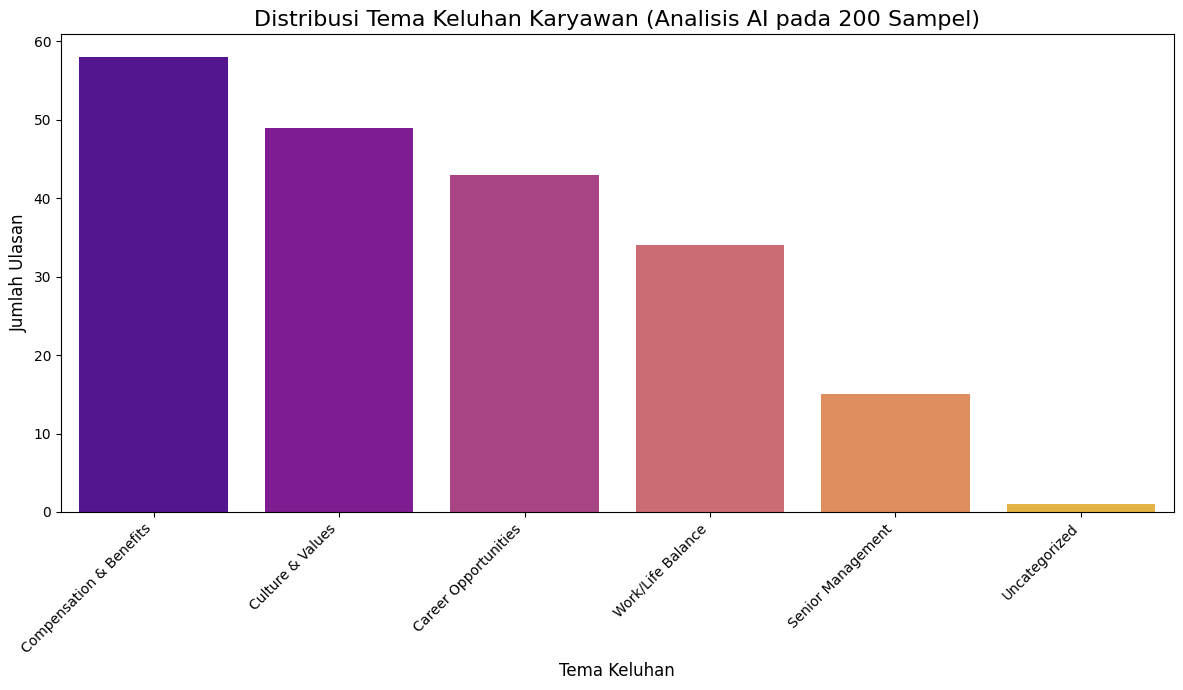


TAHAP 5 SELESAI.


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

print("Memulai analisis pada skala yang lebih besar (200 sampel)...")
print("PERINGATAN: Proses ini akan memakan waktu cukup lama (sekitar 10-15 menit). Harap bersabar.")

# Ambil 200 baris pertama sebagai sampel
large_sample_df = df.head(200).copy()

# Kita gunakan kembali fungsi 'classify_theme' dari tahap sebelumnya
# Menerapkan fungsi AI ke setiap baris di sampel data yang lebih besar
# Kita akan tambahkan timer untuk melihat berapa lama prosesnya
start_time = time.time()
large_sample_df['theme'] = large_sample_df['cons_cleaned'].apply(classify_theme)
end_time = time.time()

print(f"\nKlasifikasi pada 200 sampel selesai dalam {((end_time - start_time) / 60):.2f} menit.")

# --- Pembersihan dan Visualisasi Hasil Skala Besar ---

print("\nMembersihkan hasil AI dari analisis skala besar...")
# Kita gunakan kembali fungsi 'extract_clean_theme' dari tahap sebelumnya
large_sample_df['theme_cleaned'] = large_sample_df['theme'].apply(extract_clean_theme)
print("Pembersihan selesai.")

print("\nMembuat visualisasi baru dari 200 sampel...")
# Hitung jumlah setiap tema dari kolom yang sudah bersih
large_theme_counts = large_sample_df['theme_cleaned'].value_counts()

# Buat plot baru
plt.figure(figsize=(12, 7))
sns.barplot(x=large_theme_counts.index, y=large_theme_counts.values, palette="plasma")
plt.title('Distribusi Tema Keluhan Karyawan (Analisis AI pada 200 Sampel)', fontsize=16)
plt.xlabel('Tema Keluhan', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\nTAHAP 5 SELESAI.")


##Tahap 6: Summarization Otomatis untuk Insight Mendalam

Ini adalah tahap "faktor wow" dari proyek saya. Setelah saya berhasil mengklasifikasikan keluhan utama, saya akan melangkah lebih jauh dari sekadar analisis kuantitatif. Pada tahap ini, saya akan menunjukkan bagaimana saya memanfaatkan kemampuan canggih dari AI IBM Granite untuk melakukan Summarization (Meringkas).

Saya akan memerintahkan AI untuk bertindak sebagai seorang konsultan HR profesional. Saya memberikan instruksi agar AI membaca semua keluhan yang termasuk dalam tema paling dominan, yaitu Compensation & Benefits, dan mensintesis informasi tersebut menjadi sebuah ringkasan eksekutif 3 poin.

Melalui proses ini, saya mengubah puluhan data kualitatif yang berantakan menjadi sebuah insight strategis yang ringkas, jernih, dan siap disajikan kepada level manajemen. Ini adalah bukti nyata bagaimana saya, sebagai seorang analis, dapat menggunakan AI sebagai partner yang kuat dalam pengambilan keputusan bisnis.

In [34]:
import textwrap

print("Memulai tahap akhir: Summarization Otomatis...")

try:
    # 1. Filter semua ulasan yang diklasifikasikan sebagai 'Compensation & Benefits'
    compensation_reviews_df = large_sample_df[large_sample_df['theme_cleaned'] == 'Compensation & Benefits']
    print(f"\nDitemukan {len(compensation_reviews_df)} ulasan tentang 'Compensation & Benefits'.")

    # 2. Gabungkan semua teks keluhan menjadi satu blok teks besar
    all_complaints_text = " ".join(compensation_reviews_df['cons_cleaned'].tolist())

    # 3. Rancang Prompt Summarization yang Profesional
    # Di sini kita memerintahkan AI untuk bertindak sebagai seorang konsultan
    summarization_prompt = f"""
    Act as a professional HR consultant. You have analyzed numerous employee complaints regarding 'Compensation & Benefits'.
    Read all the following complaints and write a concise 3-point summary memo for a senior manager.
    Each point should highlight a key recurring problem.

    Complaints Data:
    "{all_complaints_text}"

    Executive Summary Memo:
    """

    print("\nMengirim data ke AI untuk diringkas... (Proses ini mungkin memakan waktu)")
    # 4. Panggil AI untuk meringkas
    executive_summary = llm.invoke(summarization_prompt)
    print("Summarization selesai.")

    # 5. Tampilkan hasil ringkasan dengan format yang rapi
    print("\n--- RINGKASAN EKSEKUTIF UNTUK MANAJEMEN ---")
    # textwrap.fill digunakan untuk merapikan teks yang panjang
    print(textwrap.fill(executive_summary, width=80))

    print("\n\nTAHAP 6 SELESAI. SELURUH ANALISIS TEKNIS BERHASIL DILAKUKAN!")

except NameError:
    print("\n--- ERROR ---")
    print("DataFrame 'large_sample_df' tidak ditemukan. Pastikan Tahap 5 berjalan tanpa error.")
except Exception as e:
    print(f"\n--- ERROR ---")
    print(f"Terjadi error saat melakukan summarization: {e}")



Memulai tahap akhir: Summarization Otomatis...

Ditemukan 58 ulasan tentang 'Compensation & Benefits'.

Mengirim data ke AI untuk diringkas... (Proses ini mungkin memakan waktu)
Summarization selesai.

--- RINGKASAN EKSEKUTIF UNTUK MANAJEMEN ---
**Executive Summary Memo**  To: Senior Management  From: HR Consultant  Subject:
Key Recurring Complaints Regarding Compensation & Benefits  After a thorough
analysis of numerous employee complaints, the following three key recurring
problems with compensation and benefits have been identified:  1. **Inadequate
Salaries & Slow Progression:** Employees consistently report that salaries are
significantly lower than market competitors, even with progression into roles
with more responsibility. This lack of salary growth disincentivizes hard work
and contributes to high staff turnover. The absence of a clear salary ladder
further exacerbates the issue, leading to perceived unfairness and frustration.
2. **Poor Training & Development Opportunities:*